In [ ]:
 # replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [ ]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno

import numpy as np
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


# Patients with elective surgery

In [ ]:
%%bigquery es_paitents --project spring-carving-271217

SELECT DISTINCT
  patientunitstayid,
  electiveSurgery,

FROM
  `physionet-data.eicu_crd.apachepredvar`
WHERE
  electiveSurgery = 1


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
es_paitents

,patientunitstayid,electiveSurgery
0,2473091,1
1,3196197,1
2,191381,1
3,305789,1
4,464827,1
...,...,...
29700,1721293,1
29701,3006982,1
29702,3185345,1
29703,3199641,1


# Lab results

In [ ]:
def create_subquery(pairs_table,
                    sao2_time,
                    var_type,
                    var_name,
                    var_new_name,
                    var_window_low_hr,
                    var_window_upper_hr,
                    var_source_table,
                    var_foreign_key,
                    var_timestamp):



    if sao2_time == "offset_icu_admit":
      time_diff = f"table.{var_timestamp} - pairs.{sao2_time} "

    return f"""
    {var_type}_{var_name} AS (
      SELECT * FROM (
        SELECT
          pairs.{var_foreign_key},
          {var_name},
          pairs.{sao2_time},
          {time_diff} AS delta_{var_type}_{var_new_name},
          ROW_NUMBER() OVER(PARTITION BY pairs.{var_foreign_key}, pairs.{sao2_time}
                            ORDER BY ABS({time_diff}) ASC) AS seq
        FROM `{pairs_table}` pairs
        LEFT JOIN `{var_source_table}` AS table
        ON table.{var_foreign_key} = pairs.{var_foreign_key}
        AND {var_name} IS NOT NULL
        AND {time_diff} BETWEEN {var_window_low_hr} * 60 AND {var_window_upper_hr} * 60
      )
      WHERE seq = 1
    )
    """

In [ ]:
def create_complete_query(pairs_table, vars_df, temporal_time):

  subquery_list = []

  # Iterate over each row in df
  for index, row in vars_df.iterrows():

      subquery = create_subquery(pairs_table,
                                 temporal_time,
                                 row['var_type'],
                                 row['var_name'],
                                 row['var_new_name'],
                                 row['var_window_low_hr'],
                                 row['var_window_upper_hr'],
                                 row['var_source_table'],
                                 row['var_foreign_key'],
                                 row['var_timestamp'])
      subquery_list.append(subquery)

  # Now you have your subqueries, join them into one string
  subquery_string = ",\n\n".join(subquery_list)
  final_query = f"""
  WITH
  {subquery_string}
  SELECT
      pairs.*,
      {" , ".join([f"{row.var_type}_{row.var_name}.delta_{row.var_type}_{row.var_new_name}, {row.var_type}_{row.var_name}.{row.var_name} AS {row.var_type}_{row.var_new_name}" for index, row in vars_df.iterrows()])}
  FROM `{pairs_table}` pairs
  {" ".join([f"LEFT JOIN {row.var_type}_{row.var_name} ON {row.var_type}_{row.var_name}.{row.var_foreign_key} = pairs.{row.var_foreign_key} AND {row.var_type}_{row.var_name}.{temporal_time} = pairs.{temporal_time}" for index, row in vars_df.iterrows()])}
  """
  return final_query

In [ ]:
# %%bigquery lab_results --project spring-carving-271217

# WITH labs_filtered AS (
#   SELECT
#     patientunitstayid,
#     LOWER(labname) AS labname,
#     labresult,
#     labresultoffset,
#     ROW_NUMBER() OVER (
#       PARTITION BY patientunitstayid, LOWER(labname)
#       ORDER BY ABS(labresultoffset + 1440)
#     ) AS rn
#   FROM
#     `physionet-data.eicu_crd.lab`
#   WHERE
#     LOWER(labname) IN ('albumin', 'pt - inr', 'creatinine', 'wbc x 1000', 'glucose', 'bedside glucose')
#     AND labresultoffset < 0
# )

# SELECT
#   patientunitstayid,
#   MAX(CASE WHEN labname = 'albumin' THEN labresult END) AS albumin_result,
#   MAX(CASE WHEN labname = 'albumin' THEN labresultoffset END) AS albumin_offset,
#   MAX(CASE WHEN labname = 'pt - inr' THEN labresult END) AS pt_inr_result,
#   MAX(CASE WHEN labname = 'pt - inr' THEN labresultoffset END) AS pt_inr_offset,
#   MAX(CASE WHEN labname = 'creatinine' THEN labresult END) AS creatinine_result,
#   MAX(CASE WHEN labname = 'creatinine' THEN labresultoffset END) AS creatinine_offset,
#   MAX(CASE WHEN labname = 'wbc x 1000' THEN labresult END) AS wbc_result,
#   MAX(CASE WHEN labname = 'wbc x 1000' THEN labresultoffset END) AS wbc_offset,
#   MAX(CASE WHEN labname IN ('glucose', 'bedside glucose') THEN labresult END) AS glucose_result,
#   MAX(CASE WHEN labname IN ('glucose', 'bedside glucose') THEN labresultoffset END) AS glucose_offset


# FROM labs_filtered
# WHERE rn = 1
# GROUP BY patientunitstayid
# ORDER BY patientunitstayid;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# lab_results

,patientunitstayid,albumin_result,albumin_offset,pt_inr_result,pt_inr_offset,creatinine_result,creatinine_offset,wbc_result,wbc_offset,glucose_result,glucose_offset
0,141178,4.0,-280,NaN,<NA>,0.70,-280,7.6,-280,77.0,-280
1,141194,3.0,-923,1.10,-923,2.94,-923,11.8,-923,138.0,-923
2,141197,2.9,-179,NaN,<NA>,0.93,-179,29.5,-179,162.0,-179
3,141203,1.7,-1580,7.40,-1580,0.33,-1580,10.2,-1580,150.0,-25
4,141208,4.7,-139,NaN,<NA>,0.80,-139,11.1,-139,86.0,-139
...,...,...,...,...,...,...,...,...,...,...,...
136958,3353226,NaN,<NA>,NaN,<NA>,4.88,-221,20.9,-221,175.0,-221
136959,3353235,NaN,<NA>,NaN,<NA>,1.04,-310,5.4,-310,100.0,-310
136960,3353251,3.3,-60,1.05,-217,1.81,-217,41.8,-60,305.0,-217
136961,3353254,3.9,-256,1.03,-256,2.38,-256,13.5,-256,181.0,-256


In [ ]:
# lab_columns = [
#     'albumin_result', 'albumin_offset',
#     'pt_inr_result', 'pt_inr_offset',
#     'creatinine_result', 'creatinine_offset',
#     'wbc_result', 'wbc_offset',
#     'glucose_result', 'glucose_offset'
# ]

# missing_percent = (lab_results[lab_columns].isnull().mean() * 100).round(2)

# print(missing_percent)


albumin_result       36.25
albumin_offset       36.22
pt_inr_result        43.53
pt_inr_offset        43.38
creatinine_result    12.52
creatinine_offset    12.45
wbc_result           11.81
wbc_offset           11.78
glucose_result        3.78
glucose_offset        3.67
dtype: float64


# demographics calc

In [ ]:
# Grab patient info from derived ICU stays table and patient table
%%bigquery eicu_patv2 --project aiwonglab

SELECT DISTINCT
    icu.uniquepid AS subject_id,
    icu.patienthealthsystemstayid AS hospital_admission_id,
    icu.patientunitstayid AS patientunitstayid,
    hosp.region,
    CASE
        WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
        ELSE icu.age
    END AS admission_age,
    CASE
        WHEN pat.gender = "Female" THEN 1
        ELSE 0
    END AS sex_female,
    icu.admissionweight AS weight_admission,
    icu.admissionheight AS height_admission,
    CASE
        WHEN icu.admissionheight > 0 THEN icu.admissionweight / (POWER(icu.admissionheight / 100, 2))
        ELSE NULL
    END AS BMI_admission,
    icu.hospitaladmitoffset AS offset_hospital_admit,
    icu.hospitaldischargeoffset AS offset_hospital_discharge,
    icu.unitadmitoffset AS offset_icu_admit,
    icu.unitdischargeoffset AS offset_icu_discharge,
    (icu.hospitaldischargeoffset - icu.hospitaladmitoffset) / 60 AS los_hospital,
    icu.icu_los_hours AS los_ICU,
    icu.hosp_mort AS in_hospital_mortality,
    pat.ethnicity AS race_ethnicity,
    pat.hospitalDischargeStatus AS clinical_outcome,
    pat.unitType AS icu_unit,
-- ICU stays
FROM `physionet-data.eicu_crd_derived.icustay_detail` AS icu

-- patient info
LEFT JOIN `physionet-data.eicu_crd.patient` AS pat
ON pat.patienthealthsystemstayid = icu.patienthealthsystemstayid

LEFT JOIN `physionet-data.eicu_crd.hospital` AS hosp
ON pat.hospitalid = hosp.hospitalid

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
eicu_patv2

,subject_id,hospital_admission_id,patientunitstayid,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,offset_hospital_admit,offset_hospital_discharge,offset_icu_admit,offset_icu_discharge,los_hospital,los_ICU,in_hospital_mortality,race_ethnicity,clinical_outcome,icu_unit
0,017-101927,1312508,1683112,Midwest,90,1,39.70,147.3,18.297216,-15285,13473,0,7190,479.300000,120.0,0,Caucasian,Alive,Med-Surg ICU
1,017-101927,1297391,1665938,Midwest,90,1,46.50,147.0,21.518812,-114,9711,0,9495,163.750000,158.0,1,Caucasian,Expired,Med-Surg ICU
2,017-101927,1312508,1683111,Midwest,90,1,NaN,147.3,NaN,-22673,6085,0,45,479.300000,1.0,0,Caucasian,Alive,Med-Surg ICU
3,017-104087,1326893,1699570,Midwest,58,0,104.30,187.9,29.541378,-780,1368,0,1368,35.800000,23.0,0,Caucasian,Alive,Med-Surg ICU
4,017-104087,1319437,1691029,Midwest,58,0,101.20,187.9,28.663350,-663,2993,0,1549,60.933333,26.0,0,Caucasian,Alive,Med-Surg ICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212530,016-7057,1204602,1561937,Midwest,56,0,131.54,182.9,39.321532,-7667,2881,0,33,175.800000,1.0,0,Caucasian,Alive,Med-Surg ICU
212531,017-34181,1264110,1627894,Midwest,74,0,62.60,182.9,18.713151,-3651,28158,0,15509,530.150000,258.0,0,Caucasian,Alive,Cardiac ICU
212532,017-47497,1243760,1604731,Midwest,74,0,92.00,182.9,27.501755,-79,4418,0,1686,74.950000,28.0,<NA>,Caucasian,,Cardiac ICU
212533,017-85071,1324283,1696576,Midwest,84,0,88.40,182.9,26.425600,-170,16167,0,4771,272.283333,80.0,0,Caucasian,Alive,CTICU


## merge

In [ ]:
eicu_patv2_filtered = eicu_patv2.drop_duplicates(subset='patientunitstayid', keep='first')

In [ ]:
merged_df = es_paitents.merge(
    eicu_patv2_filtered,
    how='left',
    on='patientunitstayid'
)
merged_df

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,offset_hospital_admit,offset_hospital_discharge,offset_icu_admit,offset_icu_discharge,los_hospital,los_ICU,in_hospital_mortality,race_ethnicity,clinical_outcome,icu_unit
0,2473091,1,022-28767,1965023,Midwest,69,0,110.30,167.6,39.266978,-1430,6927,0,2715,139.283333,45.0,0,Other/Unknown,Alive,Neuro ICU
1,3196197,1,032-1822,2599706,South,61,1,57.00,167.0,20.438166,-7100,9931,0,3983,283.850000,66.0,0,Caucasian,Alive,MICU
2,191381,1,002-77128,167869,Midwest,88,0,70.30,172.7,23.570601,-8773,27486,0,19130,604.316667,319.0,0,Caucasian,Alive,Neuro ICU
3,305789,1,003-17699,264415,Midwest,84,0,84.90,172.7,28.465775,-1186,41420,0,19176,710.100000,320.0,1,Caucasian,Expired,Med-Surg ICU
4,464827,1,005-71661,394668,South,89,0,NaN,177.8,NaN,-6528,22747,0,1995,487.916667,33.0,0,Hispanic,Alive,Neuro ICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29700,1721293,1,018-8922,1345885,Midwest,76,0,95.30,177.8,30.145979,-1914,5617,0,5617,125.516667,94.0,0,Caucasian,Alive,SICU
29701,3006982,1,029-5446,2436812,Midwest,71,0,76.80,175.3,24.991791,-1765,21923,0,21923,394.800000,365.0,0,Caucasian,Alive,CCU-CTICU
29702,3185345,1,032-9109,2590777,South,63,0,77.10,177.0,24.609786,-3627,2350,0,2350,99.616667,39.0,0,African American,Alive,SICU
29703,3199641,1,032-17862,2602601,South,34,1,89.80,167.0,32.199075,-1252,3595,0,3595,80.783333,60.0,0,African American,Alive,SICU


# Lab Results

In [ ]:
pairs = {}
pairs["eicu2"] = merged_df

project_id = "beaming-courage-280500"
dataset_id = "test"

def create_table_id(project_id, dataset_id, tab_id):

  return f"{project_id}.{dataset_id}.{tab_id}"

for t_name, t_df in pairs.items():

  table_id = create_table_id(project_id, dataset_id, t_name)
  t_df.to_gbq(table_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 9986.44it/s]


In [ ]:
def get_vars_df(sheet_id, gid):

  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

In [ ]:
sao2_time = "offset_icu_admit"
pairs_table = "beaming-courage-280500.test.eicu2"

sheet_id = "1IaTHHpw2fZg7ntf_bymwJf_th5RPCOLwymmCyxNGnYc"
gid = "326954316"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, sao2_time)
# print(query)
client = bigquery.Client(project='beaming-courage-280500')
lab_results = client.query(query).to_dataframe()

In [ ]:
lab_results

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,...,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_hfp_albumin,hfp_albumin
0,306613,1,003-4368,265145,None,71,1,NaN,NaN,NaN,...,-1263,94.0,-1263,26.0,-1263,1.20,-1263,118.0,-1263,2.8
1,453985,1,005-56009,385950,None,78,1,44.4,152.4,19.116705,...,-2247,93.0,-2247,29.0,-2247,4.20,-2247,112.0,-3252,3.2
2,2460170,1,022-78117,1954222,None,82,0,103.4,167.6,36.810567,...,-793,85.0,-793,28.0,-793,1.50,-793,104.0,-882,2.8
3,2868472,1,027-35977,2323784,None,18,1,46.5,168.0,16.475340,...,-947,94.0,-947,35.0,-947,1.70,-947,117.0,-3702,4.3
4,2671557,1,027-186479,2141359,None,36,0,98.6,172.7,33.059192,...,-933,94.0,-933,30.0,-933,1.55,-933,123.0,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29700,2814651,1,027-210945,2273986,West,75,0,60.0,178.0,18.937003,...,-1274,111.0,-1274,30.0,-1274,0.64,-641,113.0,-1274,2.0
29701,577795,1,006-195541,477134,West,55,0,103.6,170.0,35.847751,...,-949,111.0,-949,24.0,-949,1.40,-949,234.0,-949,3.7
29702,2689291,1,027-166125,2157753,West,36,0,72.6,165.1,26.634373,...,-1005,111.0,-1005,26.0,-1005,0.35,-1005,91.0,<NA>,NaN
29703,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,-826,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5


In [ ]:
missingness = (lab_results.isnull().mean() * 100).round(2)

missingness_df = missingness.reset_index()
missingness_df.columns = ['column', 'missing_percent']

missingness_df

,column,missing_percent
0,patientunitstayid,0.00
1,electiveSurgery,0.00
2,subject_id,0.00
3,hospital_admission_id,0.00
4,region,7.13
5,admission_age,0.00
6,sex_female,0.00
7,weight_admission,2.85
8,height_admission,0.85
9,BMI_admission,3.20


In [ ]:
# Grab vent info from derived ICU stays table and patient table
  %%bigquery vent --project aiwonglab

  SELECT
    patientunitstayid,
    CASE
      WHEN priorVentEndOffset > 0 THEN 1
      ELSE 0
    END AS prior_ventilation_indicator
  FROM
    `physionet-data.eicu_crd.respiratorycare`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
vent

,patientunitstayid,prior_ventilation_indicator
0,961182,1
1,978989,1
2,1554686,1
3,1565679,1
4,1565894,1
...,...,...
865376,3136307,0
865377,3160046,0
865378,3137481,0
865379,3150646,0


In [ ]:
# Count distribution
distribution = vent['prior_ventilation_indicator'].value_counts().sort_index()

print(distribution)

prior_ventilation_indicator
0    740776
1    124605
Name: count, dtype: Int64


In [ ]:
merged_df_f = lab_results.merge(
    vent,
    how='left',
    on='patientunitstayid'
)
merged_df_f

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,...,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_hfp_albumin,hfp_albumin,prior_ventilation_indicator
0,306613,1,003-4368,265145,None,71,1,NaN,NaN,NaN,...,94.0,-1263,26.0,-1263,1.20,-1263,118.0,-1263,2.8,<NA>
1,453985,1,005-56009,385950,None,78,1,44.4,152.4,19.116705,...,93.0,-2247,29.0,-2247,4.20,-2247,112.0,-3252,3.2,<NA>
2,2460170,1,022-78117,1954222,None,82,0,103.4,167.6,36.810567,...,85.0,-793,28.0,-793,1.50,-793,104.0,-882,2.8,<NA>
3,2868472,1,027-35977,2323784,None,18,1,46.5,168.0,16.475340,...,94.0,-947,35.0,-947,1.70,-947,117.0,-3702,4.3,<NA>
4,2671557,1,027-186479,2141359,None,36,0,98.6,172.7,33.059192,...,94.0,-933,30.0,-933,1.55,-933,123.0,<NA>,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148444,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148445,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148446,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148447,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0


In [ ]:
# drop BMI_admission > 100
# drop rows prior_ventilation_indicator if NA

In [ ]:
distribution = merged_df_f['prior_ventilation_indicator'].value_counts().sort_index()

print(distribution)

prior_ventilation_indicator
0    97809
1    31909
Name: count, dtype: Int64


In [ ]:
# 1. Drop rows where BMI_admission > 100
merged_df_f = merged_df_f[merged_df_f['BMI_admission'] <= 100]

# 2. Drop rows where prior_ventilation_indicator is NA
merged_df_f = merged_df_f.dropna(subset=['prior_ventilation_indicator'])


In [ ]:
merged_df_f

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,...,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_hfp_albumin,hfp_albumin,prior_ventilation_indicator
18,836291,1,006-56535,632303,None,81,1,76.6,147.3,35.303948,...,89.0,-1386,39.0,-1386,0.95,-676,214.0,-1386,3.8,0
19,836291,1,006-56535,632303,None,81,1,76.6,147.3,35.303948,...,89.0,-1386,39.0,-1386,0.95,-676,214.0,-1386,3.8,0
20,836291,1,006-56535,632303,None,81,1,76.6,147.3,35.303948,...,89.0,-1386,39.0,-1386,0.95,-676,214.0,-1386,3.8,0
21,836291,1,006-56535,632303,None,81,1,76.6,147.3,35.303948,...,89.0,-1386,39.0,-1386,0.95,-676,214.0,-1386,3.8,0
23,2672545,1,027-11168,2142267,None,61,1,107.2,162.6,40.546531,...,130.0,-1206,24.0,-1206,4.12,-1206,199.0,-5526,2.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148443,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148444,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148445,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0
148446,2779697,1,027-180701,2241634,West,86,1,68.0,157.5,27.412446,...,111.0,-826,26.0,-826,0.62,-826,102.0,-3721,4.5,0


In [ ]:
# 1. Add a temporary column that counts non-missing entries in each row
merged_df_f['_non_missing_count'] = merged_df_f.notna().sum(axis=1)

# 2. Sort so rows with *more* non-missing values come first
merged_df_f = merged_df_f.sort_values(by='_non_missing_count', ascending=False)

# 3. Drop duplicates keeping the first (most complete) per patientunitstayid
merged_df_f = merged_df_f.drop_duplicates(subset='patientunitstayid', keep='first')

# 4. Drop the helper column
merged_df_f = merged_df_f.drop(columns=['_non_missing_count'])


In [ ]:
merged_df_f

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,...,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_hfp_albumin,hfp_albumin,prior_ventilation_indicator
101839,1703058,1,017-10359,1329961,Midwest,64,0,78.40,178.0,24.744350,...,95.0,-1688,30.0,-1688,0.55,-1688,112.0,-1688,3.3,0
101855,2416071,1,022-101679,1917583,Midwest,71,1,69.40,172.7,23.268843,...,95.0,-2120,30.0,-2120,0.81,-839,215.0,-2120,3.0,1
101870,224017,1,002-38478,193251,Midwest,65,1,67.90,161.3,26.097628,...,95.0,-1905,28.0,-1905,1.71,-1905,83.0,-3445,3.3,1
101873,1572833,1,016-11192,1214693,Midwest,69,0,124.28,188.0,35.162970,...,95.0,-2158,29.0,-2158,0.92,-1166,218.0,-2158,2.9,1
101882,3030498,1,029-2168,2457078,Midwest,65,1,39.00,154.9,16.254057,...,95.0,-1691,28.0,-1691,0.83,-1691,85.0,-8138,3.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,2721316,1,027-120575,2187514,None,83,1,68.00,154.9,28.340407,...,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,0
6383,2768858,1,027-212267,2231561,None,69,0,93.80,182.0,28.317836,...,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,1
5812,603202,1,006-151041,492386,None,78,0,81.50,172.0,27.548675,...,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,0
5858,2669794,1,027-212683,2139713,None,88,0,73.00,172.7,24.475873,...,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,1


In [ ]:
missingness = (merged_df_f.isnull().mean() * 100).round(2)

missingness_df = missingness.reset_index()
missingness_df.columns = ['column', 'missing_percent']

missingness_df

,column,missing_percent
0,patientunitstayid,0.00
1,electiveSurgery,0.00
2,subject_id,0.00
3,hospital_admission_id,0.00
4,region,6.22
5,admission_age,0.00
6,sex_female,0.00
7,weight_admission,0.00
8,height_admission,0.00
9,BMI_admission,0.00


In [ ]:
print(f"Before dropping NAs: {merged_df_f.shape[0]} rows")
merged_df_f = merged_df_f.dropna()
print(f"After dropping NAs: {merged_df_f.shape[0]} rows")

Before dropping NAs: 10761 rows
After dropping NAs: 1405 rows


In [ ]:
merged_df_f["ve"]

In [ ]:
merged_df_f

,patientunitstayid,electiveSurgery,subject_id,hospital_admission_id,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,...,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_hfp_albumin,hfp_albumin,prior_ventilation_indicator
101839,1703058,1,017-10359,1329961,Midwest,64,0,78.40,178.0,24.744350,...,95.0,-1688,30.0,-1688,0.55,-1688,112.0,-1688,3.3,0
101855,2416071,1,022-101679,1917583,Midwest,71,1,69.40,172.7,23.268843,...,95.0,-2120,30.0,-2120,0.81,-839,215.0,-2120,3.0,1
101870,224017,1,002-38478,193251,Midwest,65,1,67.90,161.3,26.097628,...,95.0,-1905,28.0,-1905,1.71,-1905,83.0,-3445,3.3,1
101873,1572833,1,016-11192,1214693,Midwest,69,0,124.28,188.0,35.162970,...,95.0,-2158,29.0,-2158,0.92,-1166,218.0,-2158,2.9,1
101882,3030498,1,029-2168,2457078,Midwest,65,1,39.00,154.9,16.254057,...,95.0,-1691,28.0,-1691,0.83,-1691,85.0,-8138,3.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132625,3328006,1,035-23418,2720356,South,68,0,82.10,178.0,25.912132,...,105.0,-606,25.0,-606,1.04,-606,182.0,-6283,3.8,1
132716,3337788,1,035-15911,2729156,South,79,1,74.80,149.9,33.288815,...,105.0,-2036,20.0,-2036,1.82,-695,158.0,-6143,2.5,0
132729,3168920,1,032-23767,2577057,South,59,1,59.00,150.0,26.222222,...,105.0,-1903,24.0,-1903,0.78,-1903,104.0,-1903,2.9,0
132691,3334002,1,035-310,2725724,South,62,1,90.90,175.3,29.580128,...,105.0,-2261,27.0,-2261,0.86,-649,85.0,-5314,3.6,0


In [ ]:
merged_df_f.to_csv('datathon.csv', index=False)

In [ ]:
!pip install fasterrisk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.4/478.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.3
    Uninstalling pyparsing-3.2.3:
      Successfully uninstalled pyparsing-3.2.3
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: numpy
    Found existing i

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
import math
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier


In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)

    # Store results
    global results  # Access the global results dictionary
    results[model_name] = {
        'model': model,
        'auroc': auroc,
        'auprc': auprc
    }

    print(f"{model_name} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

    return model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Import FasterRisk if you're using it
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

# Function to convert 0/1 labels to -1/+1 for FasterRisk
def convert_labels_for_fasterrisk(y):
    y_np = y.values if hasattr(y, 'values') else np.array(y)
    return 2 * y_np - 1

In [ ]:
df = pd.read_csv('datathon.csv')

In [42]:
X = df.drop(['hospital_admission_id', 'prior_ventilation_indicator',  'weight_admission', 'height_admission','patientunitstayid', 'electiveSurgery', 'subject_id', 'race_ethnicity', 'region', 'in_hospital_mortality', 'icu_unit', 'clinical_outcome'], axis=1)
y = df['prior_ventilation_indicator']

In [50]:
# Drop columns that contain 'offset' or 'delta' in their name
X = X.drop(columns=[col for col in X.columns if ('offset' in col) or ('delta' in col) or ('los' in col)])
X.columns

Index(['admission_age', 'sex_female', 'BMI_admission', 'vitals_spo2',
       'cbc_wbc', 'coag_inr', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride',
       'bmp_bicarbonate', 'bmp_creatinine', 'bmp_glucose', 'hfp_albumin'],
      dtype='object')

In [51]:
X.dtypes

,0
admission_age,float64
sex_female,float64
BMI_admission,float64
vitals_spo2,float64
cbc_wbc,float64
coag_inr,float64
bmp_sodium,float64
bmp_potassium,float64
bmp_chloride,float64
bmp_bicarbonate,float64


In [52]:
# Check data shape and handle missing values
print("Original data shape:", X.shape)
print("Number of missing values per column:")
print(X.isna().sum())

# # Imputation (using KNN)
# knn_imputer = KNNImputer(n_neighbors=5)
# X_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
# X = X_imputed_knn
# print("\nAfter imputation - remaining missing values:", X.isna().sum().sum())

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X_scaled  # Use scaled features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store results
results = {}

# Create plots directory if it doesn't exist
import os
plots_dir = 'plots_dir'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# 1. Decision Tree
dt_model = evaluate_model(
    DecisionTreeClassifier(max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Decision Tree"
)

# 2. Random Forest
rf_model = evaluate_model(
    RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Random Forest"
)

# 3. Logistic Regression
lr_model = evaluate_model(
    LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    X_train, X_test, y_train, y_test,
    "Logistic Regression"
)

# 4. Gradient Boosting
gb_model = evaluate_model(
    GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    X_train, X_test, y_train, y_test,
    "Gradient Boosting"
)

Original data shape: (1405, 13)
Number of missing values per column:
admission_age      0
sex_female         0
BMI_admission      0
vitals_spo2        0
cbc_wbc            0
coag_inr           0
bmp_sodium         0
bmp_potassium      0
bmp_chloride       0
bmp_bicarbonate    0
bmp_creatinine     0
bmp_glucose        0
hfp_albumin        0
dtype: int64
Decision Tree - AUROC: 0.5474, AUPRC: 0.5659
Random Forest - AUROC: 0.6152, AUPRC: 0.6368
Logistic Regression - AUROC: 0.5536, AUPRC: 0.6015
Gradient Boosting - AUROC: 0.5772, AUPRC: 0.6204


In [53]:
# ----- FasterRisk Implementation -----
# Convert labels
y_train_fr = convert_labels_for_fasterrisk(y_train)
y_test_fr = convert_labels_for_fasterrisk(y_test)

# Define parent_size
parent_size = 10  # Beam search parameter

# Original FasterRisk with 5 features
print("\n----- Training FasterRisk Model (Original - 5 features) -----")
original_sparsity = 5  # Number of features to use in risk score

risk_score_optimizer = RiskScoreOptimizer(X=X_train.values,
                                         y=y_train_fr,
                                         k=original_sparsity,
                                         parent_size=parent_size)


start_time = time.time()
risk_score_optimizer.optimize()
end_time = time.time()
print(f"FasterRisk optimization completed in {end_time - start_time:.2f} seconds")

# Get the optimized models
multipliers, intercepts, coefficients = risk_score_optimizer.get_models()

# Use the first model (best performing)
model_index = 0
multiplier = multipliers[model_index]
intercept = intercepts[model_index]
coefficient = coefficients[model_index]

# Create FasterRisk classifier
risk_classifier = RiskScoreClassifier(multiplier=multiplier,
                                     intercept=intercept,
                                     coefficients=coefficient,
                                     featureNames=list(X.columns),
                                     X_train=X_train.values)

# Print the model card
print("\nFasterRisk Model Card:")
risk_classifier.print_model_card()

# Create a wrapper for sklearn-compatible API
class FasterRiskWrapper:
    def __init__(self, risk_classifier):
        self.risk_classifier = risk_classifier

    def predict(self, X):
        return self.risk_classifier.predict(X=X)

    def predict_proba(self, X):
        # Get probabilities using predict_prob
        probs = self.risk_classifier.predict_prob(X=X)
        # Return in sklearn-like format
        return np.vstack((1 - probs, probs)).T

# Wrap the classifier and evaluate
risk_classifier_wrapped = FasterRiskWrapper(risk_classifier)

# Evaluate FasterRisk
y_test_prob_fr = risk_classifier.predict_prob(X=X_test.values)
test_auroc = roc_auc_score(y_test, y_test_prob_fr)
test_auprc = average_precision_score(y_test, y_test_prob_fr)

# Get accuracy and AUC directly from the model
model_acc_test, model_auc_test = risk_classifier.get_acc_and_auc(X=X_test.values, y=y_test_fr)

# Add to results
results["FasterRisk"] = {
    'model': risk_classifier_wrapped,
    'auroc': test_auroc,
    'auprc': test_auprc,
    'features_used': sum(np.array(coefficient) != 0),
    'coefficients': coefficient
}

print(f"FasterRisk - AUROC: {test_auroc:.4f}, AUPRC: {test_auprc:.4f}")


----- Training FasterRisk Model (Original - 5 features) -----
FasterRisk optimization completed in 3.38 seconds

FasterRisk Model Card:
The Risk Score is:
1.   admission_age      1 point(s) |   ...
2.      sex_female      2 point(s) | + ...
3.     vitals_spo2      1 point(s) | + ...
4.    bmp_chloride     -1 point(s) | + ...
5.     hfp_albumin     -1 point(s) | + ...
                             SCORE | =    
SCORE |  -2.0  |  -1.0  |   0.0  |   1.0  |
RISK  |  42.4% |  44.9% |  47.4% |  50.0% |
SCORE |   2.0  |   3.0  |   4.0  |
RISK  |  52.6% |  55.1% |  57.6% |
FasterRisk - AUROC: 0.5448, AUPRC: 0.5992


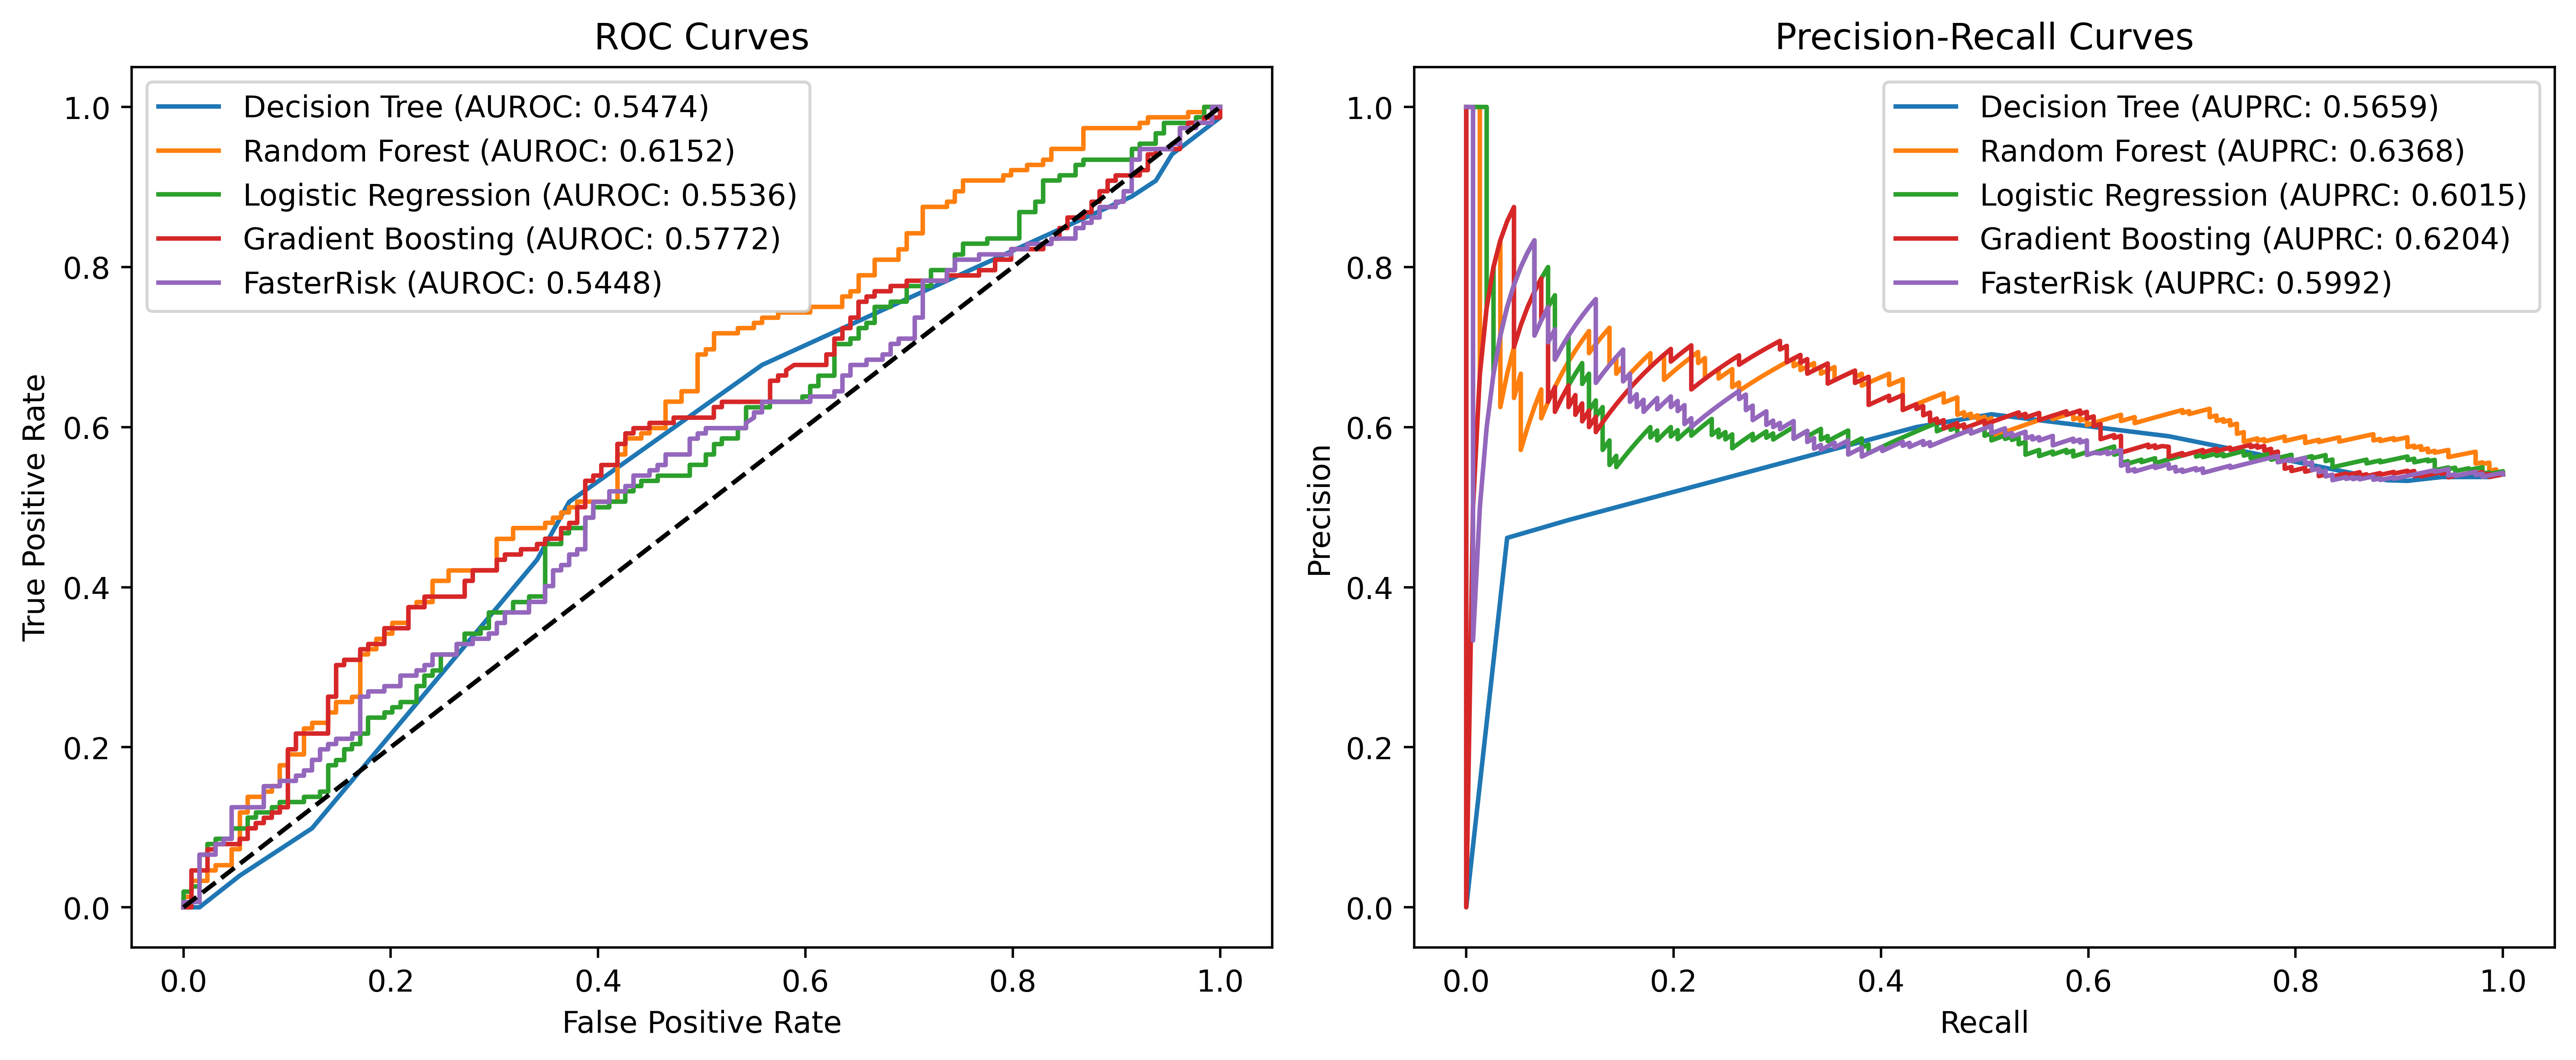

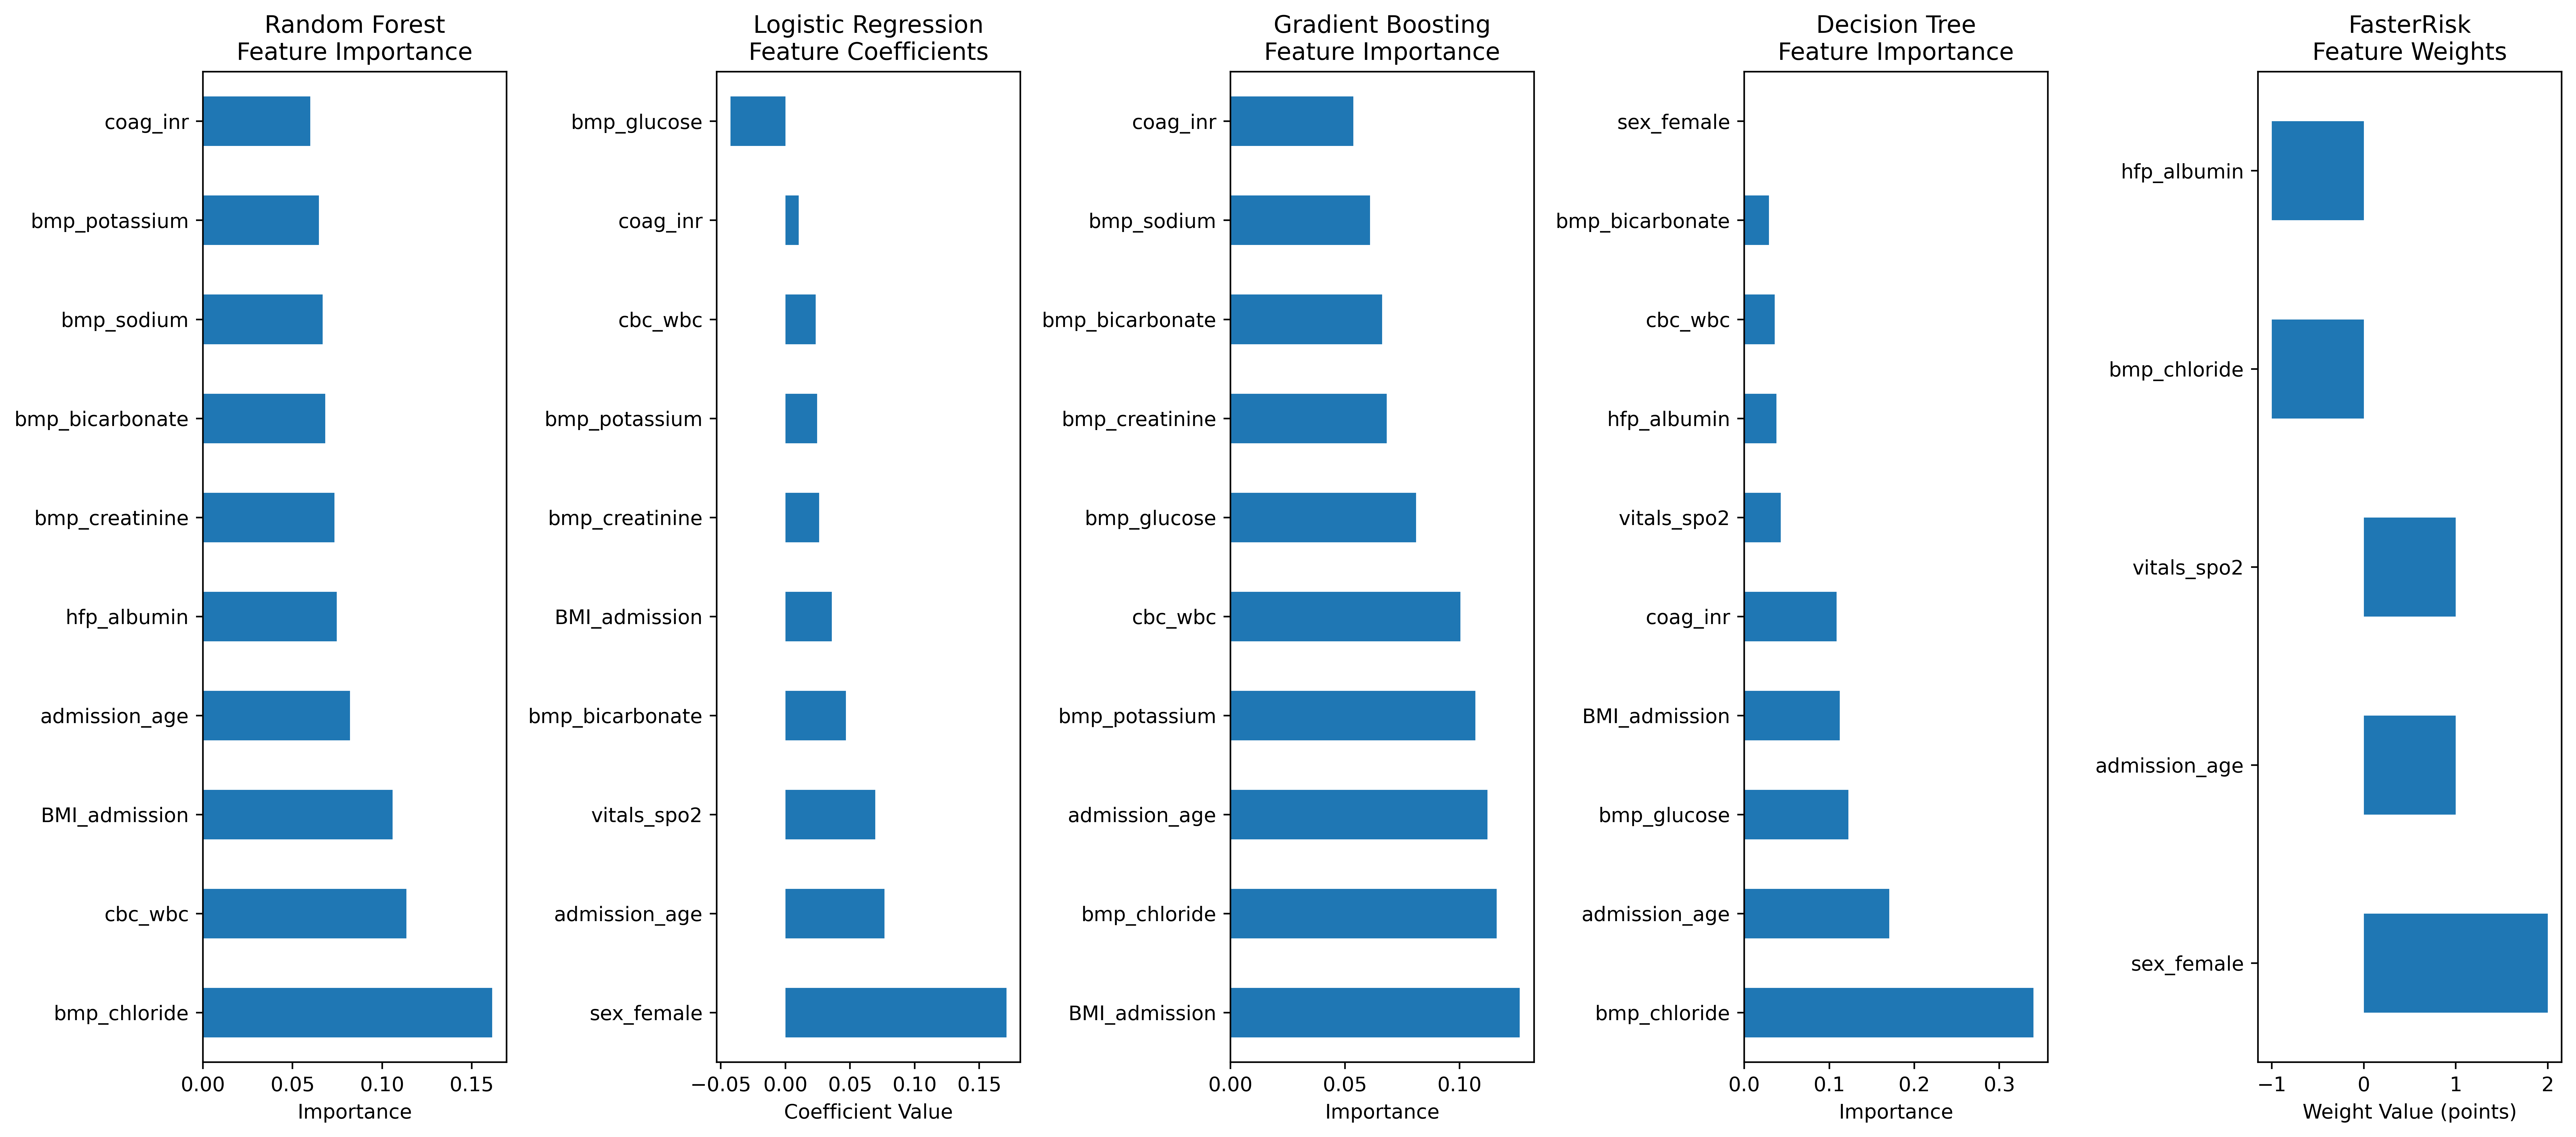

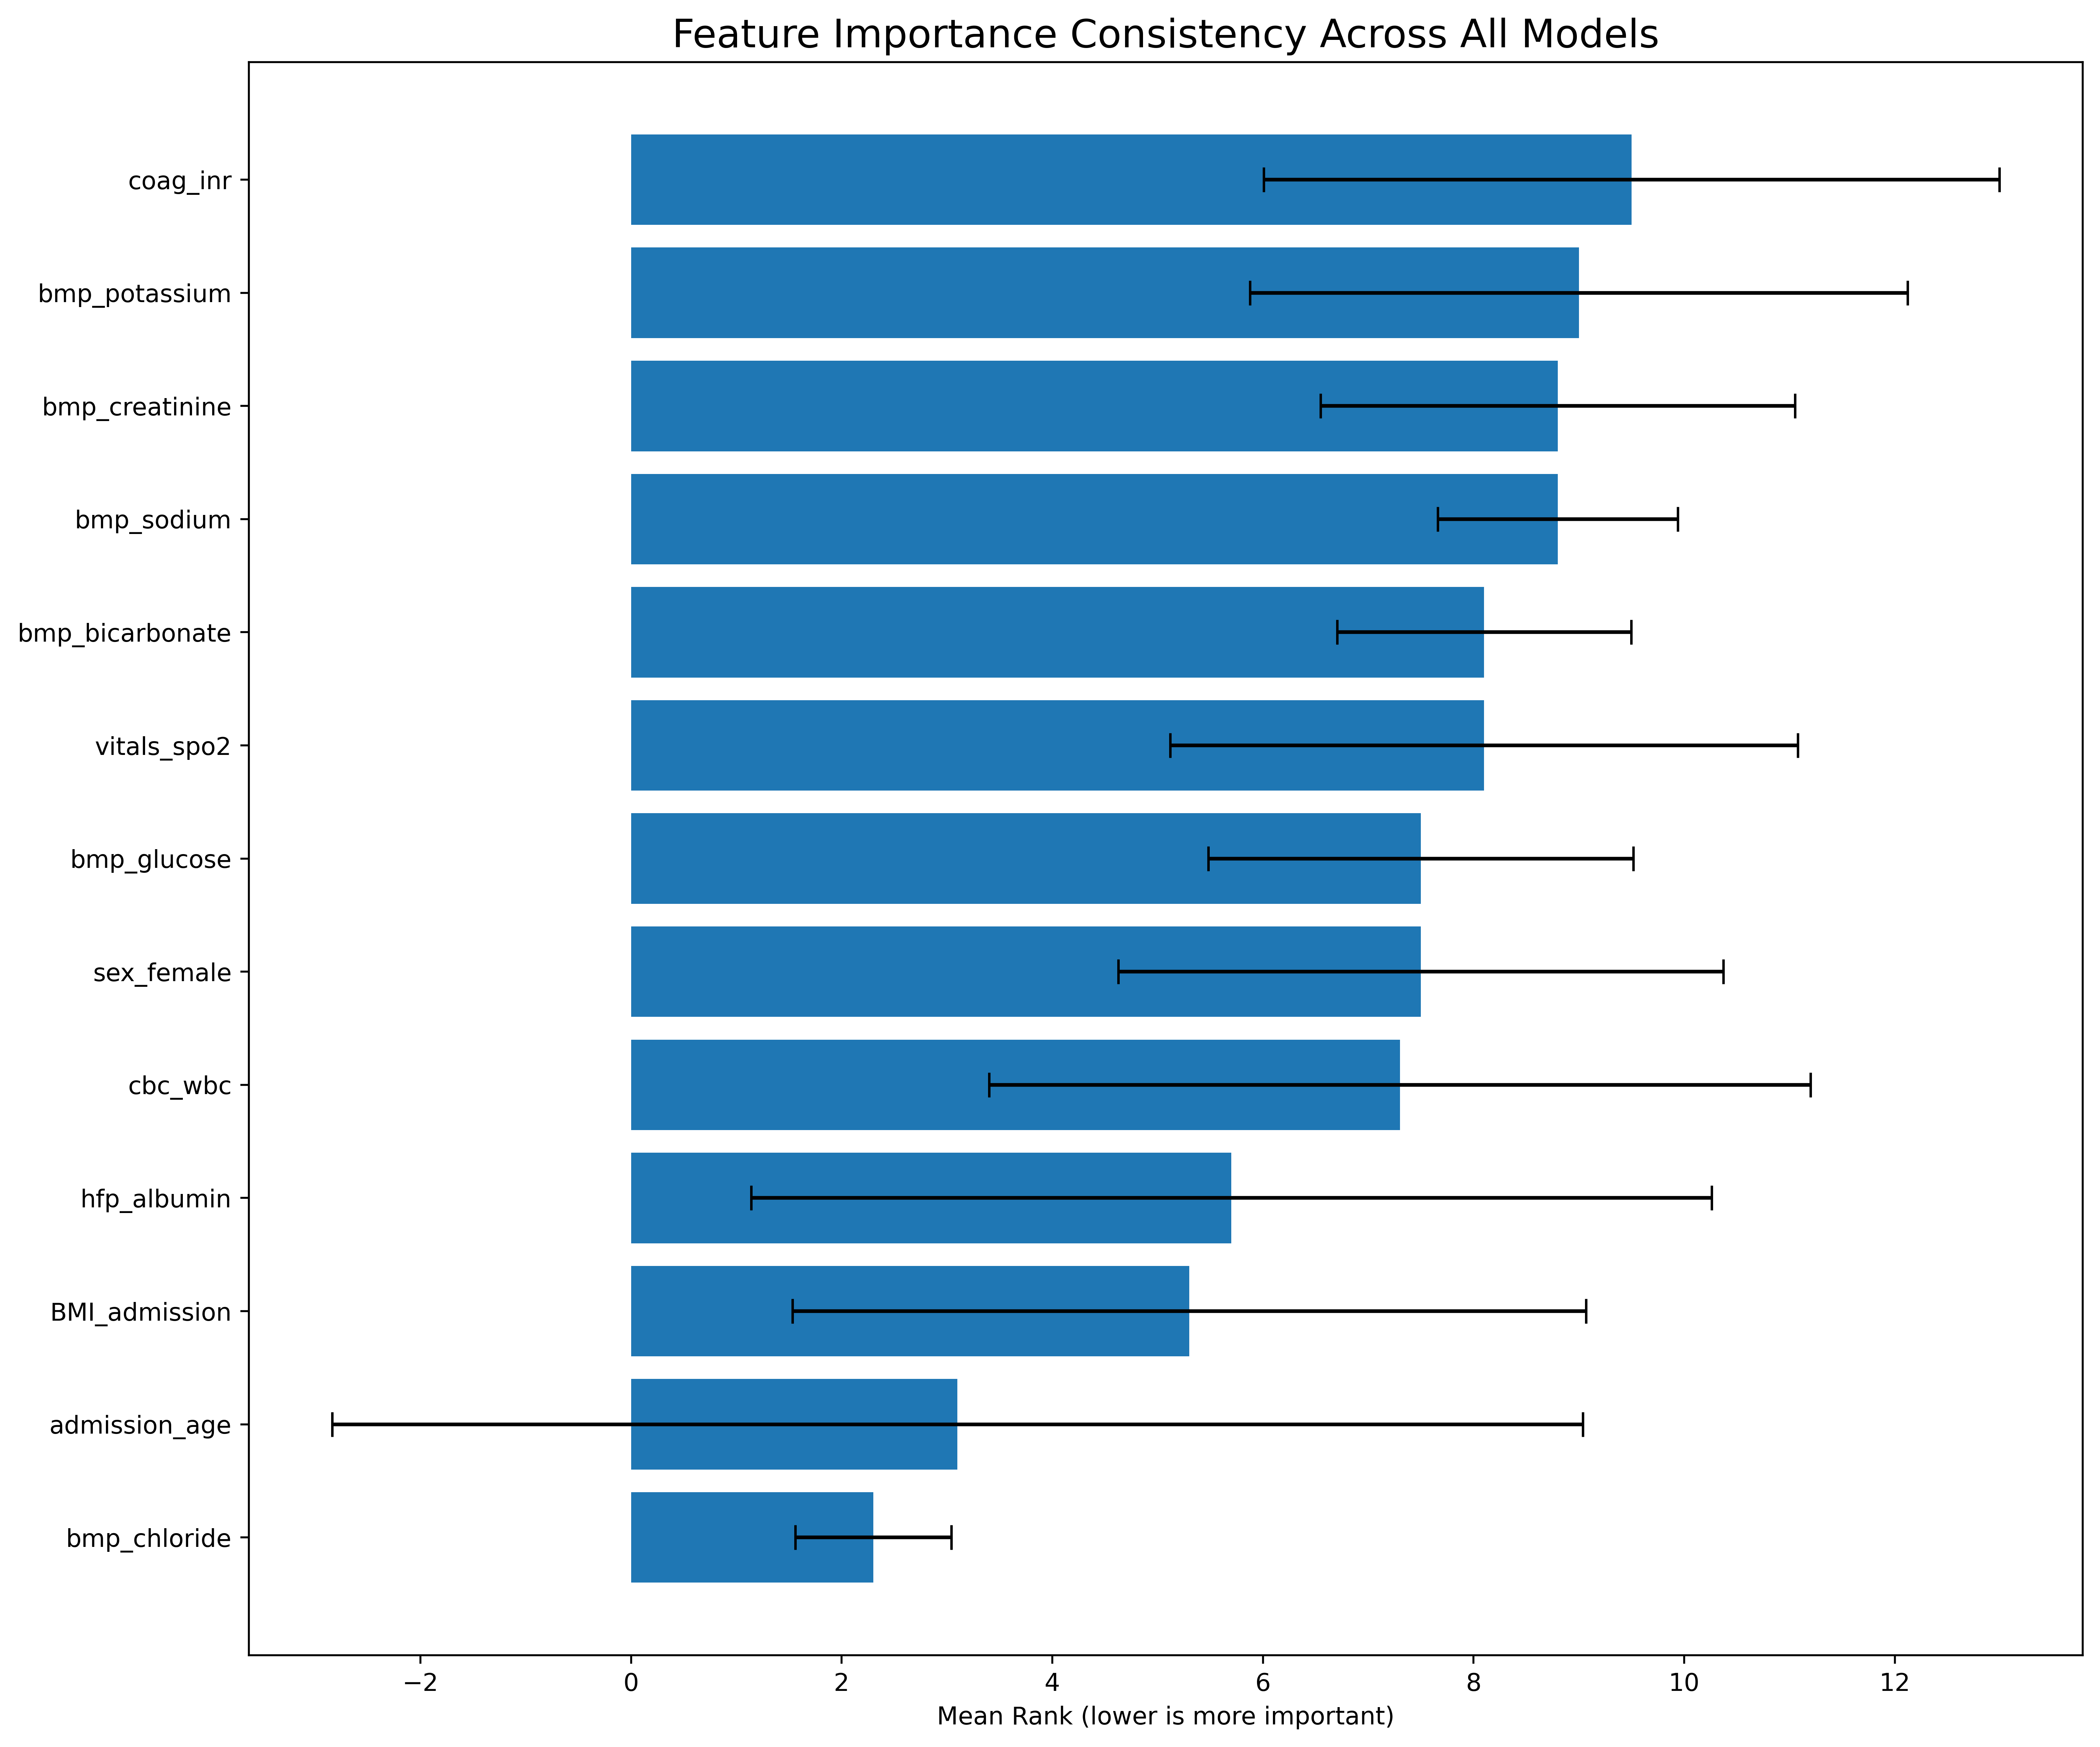


Model Performance Comparison:
Decision Tree:
  AUROC: 0.5474
  AUPRC: 0.5659
Random Forest:
  AUROC: 0.6152
  AUPRC: 0.6368
Logistic Regression:
  AUROC: 0.5536
  AUPRC: 0.6015
Gradient Boosting:
  AUROC: 0.5772
  AUPRC: 0.6204
FasterRisk:
  AUROC: 0.5448
  AUPRC: 0.5992

Top 5 Most Consistently Important Features:
- bmp_chloride
- admission_age
- BMI_admission
- hfp_albumin
- cbc_wbc

----- FasterRisk Model Interpretation -----
Risk Score Points:
  admission_age: 1.0 point(s)
  sex_female: 2.0 point(s)
  vitals_spo2: 1.0 point(s)
  bmp_chloride: -1.0 point(s)
  hfp_albumin: -1.0 point(s)
Intercept: -1.0


In [54]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 5), dpi=500)

plt.subplot(1, 2, 1)
for model_name in results:
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUROC: {results[model_name]['auroc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Plot PR curves
plt.subplot(1, 2, 2)
for model_name in results:
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{model_name} (AUPRC: {results[model_name]['auprc']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'model_comparison_curves.png'))
plt.show()

# Feature importance for all models
all_importances = pd.DataFrame(index=X.columns)

# 1. Decision Tree Feature Importance
dt_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
all_importances['Decision Tree'] = dt_importances

# 2. Random Forest Feature Importance
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
all_importances['Random Forest'] = rf_importances

# 3. Logistic Regression Coefficients
lr_importances = pd.Series(np.abs(lr_model.coef_[0]), index=X.columns)
all_importances['Logistic Regression'] = lr_importances

# Store original LR coefficients with sign for direction interpretation
lr_coef = pd.Series(lr_model.coef_[0], index=X.columns)

# 4. Gradient Boosting Feature Importance
gb_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
all_importances['Gradient Boosting'] = gb_importances

# 5. FasterRisk Feature Importance (based on absolute coefficient values)
fr_importances = pd.Series(np.abs(coefficient), index=X.columns)
all_importances['FasterRisk'] = fr_importances

# Feature importance visualization
plt.figure(figsize=(18, 8), dpi=500)

# 1. Random Forest Feature Importance
plt.subplot(1, 5, 1)
rf_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Random Forest\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 2. Logistic Regression Coefficients (with direction)
plt.subplot(1, 5, 2)
lr_coef.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Logistic Regression\nFeature Coefficients', fontsize=12)
plt.xlabel('Coefficient Value')

# 3. Gradient Boosting Feature Importance
plt.subplot(1, 5, 3)
gb_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Gradient Boosting\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 4. Decision Tree Feature Importance
plt.subplot(1, 5, 4)
dt_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Decision Tree\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 5. FasterRisk Feature Importance (with sign)
plt.subplot(1, 5, 5)
fr_coef = pd.Series(coefficient, index=X.columns)
fr_coef[fr_coef != 0].sort_values(ascending=False).plot(kind='barh')
plt.title('FasterRisk\nFeature Weights', fontsize=12)
plt.xlabel('Weight Value (points)')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_importance_comparison.png'))
plt.show()

# Create a feature importance consistency plot
mean_ranks = all_importances.rank(ascending=False).mean(axis=1).sort_values()
std_ranks = all_importances.rank(ascending=False).std(axis=1)

plt.figure(figsize=(12, 10), dpi=500)
plt.barh(mean_ranks.index, mean_ranks, xerr=std_ranks, capsize=5)
plt.xlabel('Mean Rank (lower is more important)')
plt.title('Feature Importance Consistency Across All Models', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_importance_consistency.png'))
plt.show()

# Print model performance comparison
print("\nModel Performance Comparison:")
for model_name in results:
    print(f"{model_name}:")
    print(f"  AUROC: {results[model_name]['auroc']:.4f}")
    print(f"  AUPRC: {results[model_name]['auprc']:.4f}")

# Print top 5 consistent important features
print("\nTop 5 Most Consistently Important Features:")
top_features = list(mean_ranks.head(5).index)
for feature in top_features:
    print(f"- {feature}")

# Print FasterRisk model interpretation
print("\n----- FasterRisk Model Interpretation -----")
print("Risk Score Points:")
for i, (feature, coef) in enumerate(zip(X.columns, coefficient)):
    if coef != 0:
        print(f"  {feature}: {coef} point(s)")
print(f"Intercept: {intercept}")

In [41]:
y.value_counts()

,prior_ventilation_indicator
0,718
1,687
